In [1]:
!pip install --no-index seaborn

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/seaborn-0.13.2+computecanada-py3-none-any.whl


In [15]:
import numpy as np
import pandas as pd
import h5py
import logging
from scipy.stats import pearsonr
import os
from datetime import datetime
import warnings
from abc import ABC, abstractmethod
from typing import Dict, Tuple, List, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm

@dataclass
class ReliabilityConfig:
    """Configuration for reliability analysis"""
    n_iterations: int = 500
    delays: List[int] = None
    base_dir: str = "behavioral_metrics_results"
    
    def __post_init__(self):
        if self.delays is None:
            self.delays = [100, 400, 800, 1200]

class Logger:
    """Centralized logging management"""
    def __init__(self, log_dir: str):
        self.setup_logging(log_dir)
        
    def setup_logging(self, log_dir: str):
        os.makedirs(log_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        log_file = os.path.join(log_dir, f'behavioral_metrics_{timestamp}.log')
        
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)

class BehavioralMetrics(ABC):
    """Abstract base class for behavioral metrics"""
    def __init__(
        self,
        h5_path: Optional[str] = None,
        dataset_name: Optional[str] = None,
        verbose: bool = False,
        df: Optional[pd.DataFrame] = None,
        logger: Optional[Logger] = None,
        remove_na: bool = False,
    ) -> None:
        self.logger = logger
        self.verbose = verbose
        self.remove_na = remove_na
        
        if df is not None:
            self.behavioral_data = self._preprocess_data(df)
            return

        if h5_path and dataset_name:
            self.h5_path = h5_path
            self.dataset_name = dataset_name
            self._load_and_process_h5()
        else:
            raise ValueError("Either df or (h5_path and dataset_name) must be provided")

    def _preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess the input dataframe"""
        # Create an explicit copy to avoid chained assignment warnings
        df = df.copy(deep=True)
        
        if self.verbose:
            self.logger.logger.info(f"Initial data shape: {df.shape}")

        if self.remove_na:
            df = df.dropna(subset=['correct'])
        
        if self.verbose:
            self.logger.logger.info(f"Data shape after preprocessing: {df.shape}")
        
        return df

    def _load_and_process_h5(self) -> None:
        """Load and process H5 file"""
        try:
            with h5py.File(self.h5_path, 'r') as h5_obj:
                df = pd.DataFrame(h5_obj[self.dataset_name][:]).T
                df.columns = [
                    "image_number", "fix_dur_sample", "presentation_time_ms",
                    "trial_completed", "target", "distractor", "correct",
                    "reaction_time_ms", "delay_ms", "date"
                ]
                self.behavioral_data = self._preprocess_data(df)
                
            if self.verbose:
                self.logger.logger.info("H5 file processed successfully")
                
        except Exception as e:
            self.logger.logger.error(f"Error processing H5 file: {e}")
            raise

    @abstractmethod
    def calculate_behavioral_metric(self):
        pass

class BehavioralMetricsI(BehavioralMetrics):
    """Implementation for image-based behavioral metrics"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.behavioral_metric = {"B.I1": None, "B.I2": None}
        self.calculate_behavioral_metric()

    def calculate_behavioral_metric(self) -> None:
        """Calculate B.I1 and B.I2 metrics"""
        # Create an explicit copy of the required columns
        df = self.behavioral_data[["image_number", "target", "distractor", "correct"]].copy()
        
        # Sort the copied dataframe
        df = df.sort_values(by=["target", "image_number", "distractor"])
        
        b_i1 = self.calculate_bi1(df)
        b_i2 = self.calculate_bi2(df)
        
        self.behavioral_metric = {"B.I1": b_i1, "B.I2": b_i2}
        
        if self.verbose:
            self.logger.logger.info("Behavioral metrics calculated successfully")

    @staticmethod
    def calculate_bi1(df: pd.DataFrame) -> np.ndarray:
        """Calculate B.I1 metric efficiently"""
        return df.groupby("image_number")["correct"].mean().to_numpy().reshape(-1, 1)

    @staticmethod
    def calculate_bi2(df: pd.DataFrame) -> np.ndarray:
        """Calculate B.I2 metric efficiently"""
        grouped = df.pivot_table(
            index="image_number", 
            columns="distractor", 
            values="correct", 
            aggfunc="mean"
        )
        return grouped.to_numpy()

    def get_bi1(self) -> np.ndarray:
        """Retrieve B.I1 metric"""
        return self.behavioral_metric["B.I1"]

class ReliabilityAnalyzer:
    """Handle reliability calculations and analysis"""
    def __init__(self, config: ReliabilityConfig, logger: Logger):
        self.config = config
        self.logger = logger
        self._setup_directories()
        
    def _setup_directories(self) -> None:
        """Create directory structure for results"""
        for delay in self.config.delays:
            delay_dir = os.path.join(self.config.base_dir, f'delay_{delay}ms')
            os.makedirs(delay_dir, exist_ok=True)
            os.makedirs(os.path.join(delay_dir, 'bi1'), exist_ok=True)
            
    def calculate_split_half_reliability(self, df: pd.DataFrame) -> float:
        """Calculate split-half reliability for one iteration"""
        # Create an explicit copy of the input dataframe
        df = df.copy()
        
        # Balance trials across images
        min_trials = df.groupby("image_number").size().min()
        if min_trials % 2 != 0:
            min_trials -= 1
            
        balanced_data = []
        for name, group in df.groupby("image_number"):
            group_copy = group.copy()  # Create copy of group
            if len(group_copy) > min_trials:
                balanced_data.append(group_copy.sample(n=min_trials))
            else:
                balanced_data.append(group_copy)
                
        balanced_df = pd.concat(balanced_data, ignore_index=True)
        
        # Split data and calculate metrics
        splits = []
        for name, group in balanced_df.groupby("image_number"):
            group_copy = group.copy()  # Create copy of group
            mid = len(group_copy) // 2
            splits.append((group_copy.iloc[:mid], group_copy.iloc[mid:]))
            
        df1 = pd.concat([split[0] for split in splits], ignore_index=True)
        df2 = pd.concat([split[1] for split in splits], ignore_index=True)
        
        # Calculate behavioral metrics
        metrics1 = BehavioralMetricsI(df=df1, logger=self.logger)
        metrics2 = BehavioralMetricsI(df=df2, logger=self.logger)
        
        # Calculate correlation
        correlation, _ = pearsonr(
            metrics1.get_bi1().flatten(),
            metrics2.get_bi1().flatten()
        )
        
        return 2 * correlation / (1 + correlation)
        
    def analyze_delay_reliability(
        self, 
        h5_path: str, 
        dataset_name: str,
        delay: int
    ) -> np.ndarray:
        """Analyze reliability for a specific delay"""
        self.logger.logger.info(f"Starting analysis for delay {delay}ms")
        
        # Load and filter data
        metrics = BehavioralMetricsI(
            h5_path=h5_path,
            dataset_name=dataset_name,
            logger=self.logger
        )
        
        # Create explicit copy and filter
        delay_data = metrics.behavioral_data[
            metrics.behavioral_data['delay_ms'] == delay
        ].copy()
        
        if len(delay_data) == 0:
            self.logger.logger.warning(f"No data found for delay {delay}ms")
            return np.array([])
            
        # Calculate reliabilities
        reliabilities = []
        for _ in tqdm(range(self.config.n_iterations), 
                     desc=f"Computing reliability for delay {delay}ms"):
            # Create new copy for each iteration
            shuffled_data = delay_data.sample(frac=1).reset_index(drop=True)
            reliability = self.calculate_split_half_reliability(shuffled_data)
            reliabilities.append(reliability)
            
        # Save results
        reliability_array = np.array(reliabilities)
        save_path = os.path.join(
            self.config.base_dir,
            f'delay_{delay}ms/bi1/reliabilities.npy'
        )
        np.save(save_path, reliability_array)
        
        # Log summary statistics
        self._log_summary_statistics(delay, reliability_array)
        
        return reliability_array
        
    def _log_summary_statistics(self, delay: int, reliabilities: np.ndarray) -> None:
        """Log summary statistics for reliability analysis"""
        stats = {
            'mean': np.mean(reliabilities),
            'std': np.std(reliabilities),
            'median': np.median(reliabilities),
            'min': np.min(reliabilities),
            'max': np.max(reliabilities)
        }
        
        summary_path = os.path.join(
            self.config.base_dir,
            f'delay_{delay}ms/bi1/summary.txt'
        )
        
        with open(summary_path, 'w') as f:
            f.write(f"Reliability Analysis Summary (Delay: {delay}ms)\n")
            f.write(f"Number of iterations: {len(reliabilities)}\n\n")
            for metric, value in stats.items():
                f.write(f"{metric.capitalize()}: {value:.3f}\n")
                self.logger.logger.info(f"Delay {delay}ms - {metric}: {value:.3f}")

def run_reliability_analysis(
    h5_path: str,
    dataset_name: str,
    config: Optional[ReliabilityConfig] = None
) -> Dict[int, np.ndarray]:
    """Run reliability analysis for all configured delays"""
    if config is None:
        config = ReliabilityConfig()
        
    # Setup logging and analysis
    logger = Logger(config.base_dir)
    analyzer = ReliabilityAnalyzer(config, logger)
    
    # Run analysis for each delay
    results = {}
    for delay in config.delays:
        try:
            reliabilities = analyzer.analyze_delay_reliability(
                h5_path, dataset_name.format(delay), delay
            )
            results[delay] = reliabilities
        except Exception as e:
            logger.logger.error(f"Error analyzing delay {delay}ms: {e}")
            
    return results

In [ ]:
if __name__ == "__main__":
    # Configuration
    h5_path = "data/monkey_behavioral_data/wm_delay_data_v2.h5"
    delay = 100
    dataset_name = "delay_{}"
    config = ReliabilityConfig(
        n_iterations=500,
        delays=[100, 400, 800, 1200],
        base_dir="behavioral_metrics_results"
    )
    
    # Run analysis
    try:
        results = run_reliability_analysis(h5_path, dataset_name, config)
    except Exception as e:
        print(f"Analysis failed: {e}")

2024-10-30 01:46:02,768 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-30 01:46:02,773 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


=== Reliability Analysis Summary ===

Mean Reliability by Delay:

Delay 100ms:
  Mean ± Std: 0.890 ± 0.013
  Median: 0.891
  Range: [0.835, 0.927]
  IQR: [0.882, 0.898]

Delay 400ms:
  Mean ± Std: 0.740 ± 0.030
  Median: 0.740
  Range: [0.646, 0.824]
  IQR: [0.721, 0.762]

Delay 800ms:
  Mean ± Std: 0.653 ± 0.038
  Median: 0.655
  Range: [0.542, 0.755]
  IQR: [0.626, 0.682]

Delay 1200ms:
  Mean ± Std: 0.594 ± 0.043
  Median: 0.597
  Range: [0.449, 0.719]
  IQR: [0.565, 0.622]


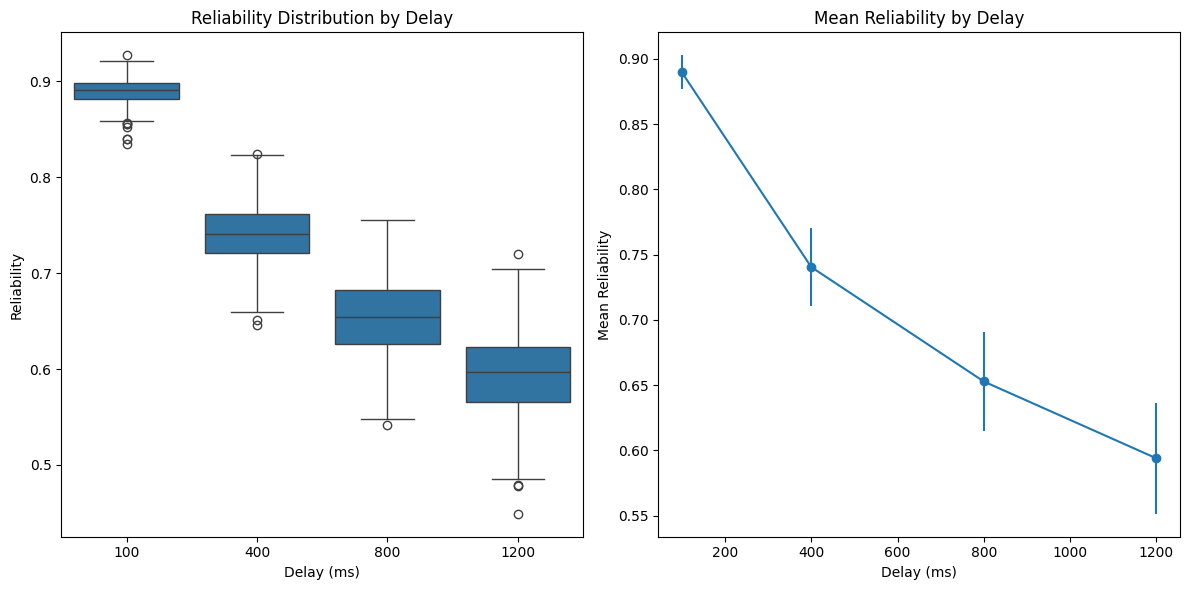

In [14]:
import numpy as np
import os
import pandas as pd
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

class ReliabilityLoader:
    """Load and analyze reliability results from .npy files"""
    def __init__(self, base_dir: str = "behavioral_metrics_results"):
        self.base_dir = base_dir
        
    def load_delay_results(self, delay: int) -> Optional[np.ndarray]:
        """Load reliability results for a specific delay"""
        file_path = os.path.join(
            self.base_dir,
            f'delay_{delay}ms/bi1/reliabilities.npy'
        )
        
        if not os.path.exists(file_path):
            print(f"No results found for delay {delay}ms")
            return None
            
        return np.load(file_path)
        
    def load_all_delays(self, delays: Optional[List[int]] = None) -> Dict[int, np.ndarray]:
        """Load results for all specified delays"""
        if delays is None:
            delays = [100, 400, 800, 1200]
            
        results = {}
        for delay in delays:
            data = self.load_delay_results(delay)
            if data is not None:
                results[delay] = data
                
        return results
        
    def compute_statistics(self, reliabilities: np.ndarray) -> Dict[str, float]:
        """Compute comprehensive statistics for reliability values"""
        return {
            'mean': np.mean(reliabilities),
            'std': np.std(reliabilities),
            'median': np.median(reliabilities),
            'min': np.min(reliabilities),
            'max': np.max(reliabilities),
            '25th_percentile': np.percentile(reliabilities, 25),
            '75th_percentile': np.percentile(reliabilities, 75),
            'skewness': stats.skew(reliabilities),
            'kurtosis': stats.kurtosis(reliabilities)
        }
        
    def analyze_all_delays(self) -> pd.DataFrame:
        """Analyze results for all delays and return as DataFrame"""
        results = self.load_all_delays()
        analysis = []
        
        for delay, reliabilities in results.items():
            stats_dict = self.compute_statistics(reliabilities)
            stats_dict['delay'] = delay
            analysis.append(stats_dict)
            
        return pd.DataFrame(analysis).set_index('delay')
    
    def plot_reliability_distributions(self, figsize: Tuple[int, int] = (12, 6)):
        """Plot reliability distributions for all delays"""
        results = self.load_all_delays()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Box plot
        delays = []
        reliabilities = []
        for delay, values in results.items():
            delays.extend([delay] * len(values))
            reliabilities.extend(values)
            
        df = pd.DataFrame({'Delay': delays, 'Reliability': reliabilities})
        sns.boxplot(x='Delay', y='Reliability', data=df, ax=ax1)
        ax1.set_title('Reliability Distribution by Delay')
        ax1.set_xlabel('Delay (ms)')
        ax1.set_ylabel('Reliability')
        
        # Line plot with error bars
        means = []
        stds = []
        delays = sorted(results.keys())
        
        for delay in delays:
            means.append(np.mean(results[delay]))
            stds.append(np.std(results[delay]))
            
        ax2.errorbar(delays, means, yerr=stds, marker='o')
        ax2.set_title('Mean Reliability by Delay')
        ax2.set_xlabel('Delay (ms)')
        ax2.set_ylabel('Mean Reliability')
        
        plt.tight_layout()
        return fig
    
    def print_summary(self):
        """Print comprehensive summary of reliability results"""
        analysis_df = self.analyze_all_delays()
        
        print("=== Reliability Analysis Summary ===\n")
        print("Mean Reliability by Delay:")
        for delay in analysis_df.index:
            print(f"\nDelay {delay}ms:")
            print(f"  Mean ± Std: {analysis_df.loc[delay, 'mean']:.3f} ± {analysis_df.loc[delay, 'std']:.3f}")
            print(f"  Median: {analysis_df.loc[delay, 'median']:.3f}")
            print(f"  Range: [{analysis_df.loc[delay, 'min']:.3f}, {analysis_df.loc[delay, 'max']:.3f}]")
            print(f"  IQR: [{analysis_df.loc[delay, '25th_percentile']:.3f}, "
                  f"{analysis_df.loc[delay, '75th_percentile']:.3f}]")
        
        return analysis_df

def load_and_analyze_results(base_dir: str = "behavioral_metrics_results"):
    """Convenience function to load and analyze all results"""
    loader = ReliabilityLoader(base_dir)
    
    # Load and analyze results
    analysis_df = loader.analyze_all_delays()
    
    # Print summary
    loader.print_summary()
    
    # Create plots
    fig = loader.plot_reliability_distributions()
    
    return analysis_df, fig

if __name__ == "__main__":
    # Example usage
    analysis_df, fig = load_and_analyze_results()
    
    # Save figure if needed
    fig.savefig('reliability_distributions.png', dpi=300, bbox_inches='tight')
    
    # Save analysis to CSV if needed
    analysis_df.to_csv('reliability_analysis.csv')


In [18]:
file_path = "behavioral_metrics_results/i1_reliability_delay_{}.npy"

for delay in [100, 400, 800, 1200]:
    temp = np.load(file_path.format(delay))
    print(f"")
    print(f"mean: {temp.mean()}")
    print(f"std: {temp.std()}")
    print(f"min: {temp.min()}")
    print(f"max: {temp.max()}")


mean: 0.8883750988616613
std: 0.013994418193766928
min: 0.8500786703157015
max: 0.9237713396876412

mean: 0.74081162863337
std: 0.02989888854286581
min: 0.6328818617145469
max: 0.8027083405051242

mean: 0.6558918564340963
std: 0.04281739588340682
min: 0.5412568435938723
max: 0.7521743349731377

mean: 0.590828405733597
std: 0.045210969793802576
min: 0.4464997490482033
max: 0.6918688826837387


# analysis the data

In [16]:

h5_path = "data/monkey_behavioral_data/wm_delay_data_v2.h5"
dataset_name = "delay_100"

behavioral_data = BehavioralMetricsI(
            h5_path=h5_path,
            dataset_name=dataset_name,
            remove_na=False
        )

behavioral_data = behavioral_data.behavioral_data.copy()

In [38]:
var = "   print(-76587)    "

assert var.count("print") == 1, ""
assert var.count("(") == 1 and var.count(")"), ""

var = var.strip()
var = var.replace("print", "return")
var = var.replace("(", " ")
var = var.replace(")", "")
_, number = var.split(" ")

print(f"{int(number)}")
var

-76587


'return -76587'